(13189, 1)
(13189, 1)
(13189, 1)
(13189, 1)
(13189,)
(1625,)
(1625,)
(1625,)
(1625,)
(1625,)
Number of parameters:  475
...................Epoch 200 Train 1.57408 Valid 1.58167
....................Epoch 400 Train 0.63109 Valid 0.98637
....................Epoch 600 Train 0.41813 Valid 0.24950
....................Epoch 800 Train 0.28862 Valid 0.18048
....................Epoch 1000 Train 0.19633 Valid 0.20754
....................Epoch 1200 Train 0.15159 Valid 0.16316
....................Epoch 1400 Train 0.14663 Valid 0.13839
....................Epoch 1600 Train 0.13860 Valid 0.13597
....................Epoch 1800 Train 0.13516 Valid 0.13787
....................Epoch 2000 Train 0.13330 Valid 0.13199
....................Epoch 2200 Train 0.13126 Valid 0.13115
....................Epoch 2400 Train 0.13083 Valid 0.13072
...........Training finished! Model is saved!
Test Loss: 0.00602
Relative Error: 1.73674776
RMS Error: 2.29840369
MAX Error: 11.13722973
95th Percentile Error: 4.60134343


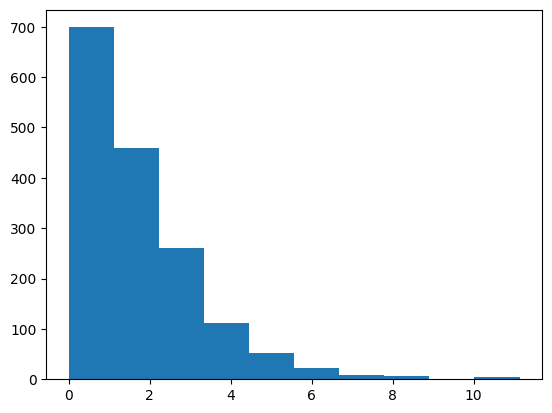

In [ ]:

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import math
import matplotlib.pyplot as plt
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define a fully connected layers model with three inputs (frequency, flux density, duty ratio) and one output (core loss).
        self.layers = nn.Sequential(
            nn.Linear(4, 20),
            nn.Tanh(),
            nn.Linear(20, 17),
            nn.Tanh(),
            nn.Linear(17, 1),
        )

    def forward(self, x):
        return self.layers(x)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_dataset():
    # Load .json Files
    with open('/content/Dataset_tri_N87_mod.json','r') as load_f:
        DATA = json.load(load_f)

    Freq = DATA['Frequency']
    Flux = DATA['Flux_Density']
    Duty = DATA['Duty_Ratio']
    Temperature = DATA['Temperature']
    Power = DATA['Power_Loss']

    # Compute labels
    # There's approximalely an exponential relationship between Loss-Freq and Loss-Flux.
    # Using logarithm may help to improve the training.
    Freq = np.log10(Freq)
    Flux = np.log10(Flux)
    Duty = np.array(Duty)
    Temperature = np.array(Temperature)
    Power = np.log10(Power)

    # Reshape data
    Freq = Freq.reshape((-1,1))
    Flux = Flux.reshape((-1,1))
    Duty = Duty.reshape((-1,1))
    Temperature = Temperature.reshape((-1,1))

    print(np.shape(Freq))
    print(np.shape(Flux))
    print(np.shape(Duty))
    print(np.shape(Temperature))
    print(np.shape(Power))

    temp = np.concatenate((Freq, Flux, Duty, Temperature),axis=1)

    in_tensors = torch.from_numpy(temp).view(-1, 4)
    out_tensors = torch.from_numpy(Power).view(-1, 1)

    # # Save dataset for future use
    # np.save("dataset.fc.in.npy", in_tensors.numpy())
    # np.save("dataset.fc.out.npy", out_tensors.numpy())

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)

def get_test():

    with open('/content/Dataset_tri_N87_pretest_mod.json','r') as load_test:
        DATA_TEST = json.load(load_test)


    Freq_t = DATA_TEST['Frequency']
    Flux_t = DATA_TEST['Flux_Density']
    Duty_t = DATA_TEST['Duty_Ratio']
    Temperature_t = DATA_TEST['Temperature']
    Power_t = DATA_TEST['Power_Loss']

    # Compute labels
    # There's approximalely an exponential relationship between Loss-Freq and Loss-Flux.
    # Using logarithm may help to improve the training.
    Freq_t = np.log10(Freq_t)
    Flux_t = np.log10(Flux_t)
    Duty_t = np.array(Duty_t)
    Temperature_t = np.array(Temperature_t)
    Power_t = np.log10(Power_t)

    print(np.shape(Freq_t))
    print(np.shape(Flux_t))
    print(np.shape(Duty_t))
    print(np.shape(Temperature_t))
    print(np.shape(Power_t))

    # Reshape data
    Freq_t = Freq_t.reshape((-1,1))
    Flux_t = Flux_t.reshape((-1,1))
    Duty_t = Duty_t.reshape((-1,1))
    Temperature_t = Temperature_t.reshape((-1,1))

    tmp = np.concatenate((Freq_t, Flux_t, Duty_t, Temperature_t),axis=1)

    in_tensors = torch.from_numpy(tmp).view(-1, 4)
    out_tensors = torch.from_numpy(Power_t).view(-1, 1)

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)


def main():
    # Reproducibility
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hyperparameters
    NUM_EPOCH = 2500
    BATCH_SIZE = 64
    DECAY_EPOCH = 168
    DECAY_RATIO = 0.5657
    LR_INI = 0.003

    # Select GPU as default device
    device = torch.device("cuda")

    # Load dataset
    dataset = get_dataset()

    testing = get_test()

    # Split the dataset
    train_size = int(0.8 * len(dataset))
    valid_size = len(dataset)-train_size
    test_size = int(len(testing))
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    test_dataset = testing
    kwargs = {'num_workers': 0, 'pin_memory': True, 'pin_memory_device': "cuda"}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

    # Setup network
    net = Net().double().to(device)

    # Log the number of parameters
    print("Number of parameters: ", count_parameters(net))

    # Setup optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=LR_INI)

    # Train the network
    for epoch_i in range(NUM_EPOCH):

        # Train for one epoch
        epoch_train_loss = 0
        net.train()
        optimizer.param_groups[0]['lr'] = LR_INI* (DECAY_RATIO ** (0+ epoch_i // DECAY_EPOCH))

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Compute Validation Loss
        with torch.no_grad():
            epoch_valid_loss = 0
            for inputs, labels in valid_loader:
                outputs = net(inputs.to(device))
                loss = criterion(outputs, labels.to(device))

                epoch_valid_loss += loss.item()

        if (epoch_i+1)%200 == 0:
          print(f"Epoch {epoch_i+1:2d} "
              f"Train {epoch_train_loss / len(train_dataset) * 1e5:.5f} "
              f"Valid {epoch_valid_loss / len(valid_dataset) * 1e5:.5f}")

        # Progress Bar
        if (epoch_i+1)%10 == 0:
          print(".", end="", flush=True)

        ''' if(epoch_i>200):
          tmp = loss_array[epoch_i-200]- loss_array[epoch_i-1]
          if abs(tmp)<0.01:
            print("early stopping")
            break '''

    # Save the model parameters
    torch.save(net.state_dict(), "/content/Model_FNN_N87.sd")
    print("Training finished! Model is saved!")

    # Evaluation
    net.eval()
    y_meas = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            y_pred.append(net(inputs.to(device)))
            y_meas.append(labels.to(device))

    y_meas = torch.cat(y_meas, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    print(f"Test Loss: {F.mse_loss(y_meas, y_pred).item() / len(test_dataset) * 1e5:.5f}")

    yy_pred = 10**(y_pred.cpu().numpy())
    yy_meas = 10**(y_meas.cpu().numpy())

    # Relative Error
    Error_re = abs(yy_pred-yy_meas)/abs(yy_meas)*100
    Error_re_avg = np.mean(Error_re)
    Error_re_rms = np.sqrt(np.mean(Error_re ** 2))
    Error_re_max = np.max(Error_re)
    Error_re_95th = np.percentile(Error_re, 95)
    print(f"Relative Error: {Error_re_avg:.8f}")
    print(f"RMS Error: {Error_re_rms:.8f}")
    print(f"MAX Error: {Error_re_max:.8f}")
    print(f"95th Percentile Error: {Error_re_95th:.8f}")
    plt.hist(Error_re)
    plt.show()

if __name__ == "__main__":
    main()
